In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LassoCV, Lasso
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [296]:
df = pd.read_csv("data.csv")
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


DATA EXPLORATION

DATA PREPROCESSING

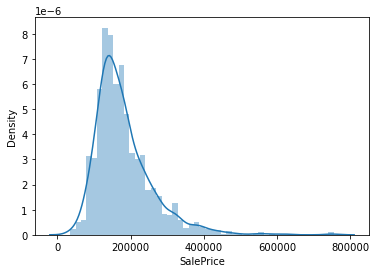

In [297]:
sns.distplot(df["SalePrice"])

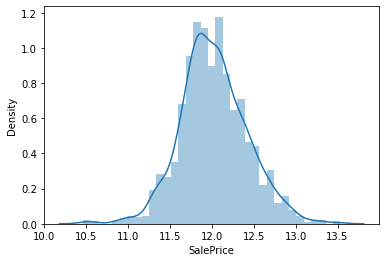

In [298]:
df["SalePrice"] = np.log1p(df["SalePrice"])
sns.distplot(df["SalePrice"])

MISSING DATA

In [299]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame(all_data_na, columns =["Missing ratio"])
missing_data

,Missing ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [300]:
replacement_dic = {
    "PoolQC":"None",
    "MiscFeature":"None",
    "Alley":"None",
    "Fence":"None",
    "FireplaceQu":"None",
    "LotFrontage":df.groupby("Neighborhood")["LotFrontage"].median(), #transform(lambda x: x.fillna(x.median())),
    "GarageType":"None",
    "GarageQual":"None",
    "GarageFinish":"None",
    "GarageCond":"None",
    "GarageYrBlt":0,
    "GarageArea":0,
    "GarageCars":0,
    "BsmtFinSF1":0,
    "BsmtFinSF2":0,
    "BsmtUnfSF":0,
    "BsmtFullBath":0,
    "BsmtHalfBath":0,
    "BsmtQual":"None",
    "BsmtCond":"None",
    "BsmtExposure":"None",
    "BsmtFinType1":"None",
    "BsmtFinType2":"None",
    "MasVnrType":"None",
    "MasVnrType":0,
    "MSZoning":df["MSZoning"].mode()[0],
    "Functional":"Typ",
    "Electrical":df["Electrical"].mode()[0]
}

def replace_nans(df,replacement_dic=replacement_dic):
    nan_cols = replacement_dic.keys()
    for col in nan_cols:
        df[col] = df[col].fillna(replacement_dic[col])

replace_nans(df,replacement_dic)
df["LotFrontage"]

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1460, dtype: float64

In [301]:
df = pd.get_dummies(df)
df = df.fillna(df.mean())
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [302]:
y = df["SalePrice"]
X = df.drop(["SalePrice"],1)

In [303]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

LASSO MODEL

LASSO EVALUATION

In [306]:
kf = KFold(n_splits=10, shuffle=True)

#lasso = Lasso(alpha=0.01)
alphas = [1,0.1,0.01,0.001,0.0001,0.00005]
scores = dict.fromkeys(aplhas,0)
for alpha in alphas:
    lasso = Lasso(alpha)
    scores[alpha]= np.sqrt(-cross_val_score(lasso, X_train,y_train, scoring ="neg_mean_squared_error", cv=kf).mean()) #RMSE
    
alpha_min = min(list(scores.items()), key=lambda x: x[1])[0]
print(alpha_min)
scores

0.0005


{1: 0.3908662155494177,
 0.1: 0.2222768760251178,
 0.001: 0.15112208725265133,
 0.0001: 0.1622138404526882,
 0.0005: 0,
 0.01: 0.14946384013763953,
 5e-05: 0.16537147302062127}

In [290]:
lasso = Lasso(alpha=alpha_min)
lasso.fit(X_train, y_train)
lasso.get_params

<bound method BaseEstimator.get_params of Lasso(alpha=0.0005)>

In [292]:
def rmse(y_true,y_pred):
    return np.sqrt(mse(y_pred,y_train))
    
y_pred = lasso.predict(X_test)
y_true = y_test
RMSE = rmse(y_pred, y_test)

note = 'replaced NaNs in all columns, Standardized'
with open('Lasso.txt','a', newline = '') as fd:
    fd.write('rmse: ' + str(RMSE) + ' alpha: ' + str(alpha_min) + " note: " + note + "\n")

In [293]:
RMSE

0.12271043673323404

In [285]:
logs = pd.read_csv("Lasso.txt")
logs

,rmse: 0.12864330225359 alpha: 0.0005 note: replaced NaNs in all columns/nrmse: 0.12864330225359 alpha: 0.0005 note: replaced NaNs in all columns
0,rmse: 0.12864330225359 alpha: 0.0005 note: rep...
1,rmse: 0.12864330225359 alpha: 0.0005 note: rep...


XGBOOST MODEL

In [316]:
xgb_reg = XGBRegressor(max_depth=3)
steps = 50

scores2 = np.sqrt(-cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=kf))
scores2

array([0.17168879, 0.12712025, 0.12822576, 0.10576398, 0.09806102,
       0.1703932 , 0.13850897, 0.12130181, 0.13404061, 0.13386582])

XGBOOST HYPERPARAMETERS TUNNING

In [ ]:
param_grid = {
    'eta':[0.05,0.1,0.15,0.20, 0.30],
    'max_depth':[3,4,6,8,10],
    'gamma':[0.0,0.1,0.2,0.3,0.4],
    'colsample_bytree':[0.3,0.4,0.5,0.6,0.8]
}
grid = GridSearchCV(xgb_reg,
                   param_grid,
                   n_jobs=-1,
                   scoring="neg_mean_squared_error",
                   cv=kf 
                   )

#grid.fit(X_train, y_train)
print("best parameters: ")
print(grid.best_params_)

In [ ]:
y_pred_gxb = grid.predict(X_test)
y_true = y_test
RMSE_xgb = rmse(y_pred, y_test)

note = 'Done Grid Search for XGBoost'
with open('XGBoost.txt','a', newline = '') as fd:
    fd.write('rmse: ' + str(RMSE_xgb) + ' params: ' + str(grid.best_params_) + " note: " + note + "\n")

OUTPUT

In [117]:
type(X_test["Id"])

pandas.core.series.Series

In [118]:
y_pred = pd.DataFrame({"Id":X_test["Id"],
                      "SalePrice":y_pred})
y_pred.reset_index(inplace=True)
y_pred = y_pred.drop(["index"],1)
y_pred

,Id,SalePrice
0,893,11.976456
1,1106,12.656177
2,414,11.611402
3,523,11.965471
4,1037,12.625066
...,...,...
287,480,11.705153
288,1362,12.298090
289,803,12.176119
290,652,11.598091
